### Stock price Predictor

Predicting stock prices Problem statement description

/** Down Jones https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI


Open: The starting price for a given trading day

Close: The final price on that day

High: The highest prices at which the stock traded on that day

Low: The lowest prices at which the stock traded on that day

Volume: The total number of shares traded before the market closed on that day

##### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np


import pandas_ta as ta #technical indicators

In [2]:
df = pd.read_csv('20051201_20051210.csv')
df

Date      Open      High       Low    Close*  Adj Close**  \
0  Dec 09, 2005  10751.76  10805.95  10729.91  10778.58     10778.58   
1  Dec 08, 2005  10808.43  10847.25  10729.67  10755.12     10755.12   
2  Dec 07, 2005  10856.86  10868.06  10764.01  10810.91     10810.91   
3  Dec 06, 2005  10835.41  10936.20  10835.41  10856.86     10856.86   
4  Dec 05, 2005  10876.95  10876.95  10810.67  10835.01     10835.01   
5  Dec 02, 2005  10912.01  10921.37  10861.66  10877.51     10877.51   
6  Dec 01, 2005  10806.03  10934.90  10806.03  10912.57     10912.57   

        Volume  
0  238930000.0  
1  253290000.0  
2  243490000.0  
3  264630000.0  
4  237340000.0  
5  214900000.0  
6  256980000.0

#### Data preparation / Cleaning

In [3]:
def clean_df(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True) #sort by date - we will use shifts later
    df.columns = df.columns.str.lower()
    df.columns =df.columns.str.replace('*','')
    
    
    #clean columns
    if 'price' in df.columns:
        
        df['close'] = df['price'].str.replace(r',', '').astype(float) #price is the closing price if from investing.com
    df = df.astype(str)
    
    df['open'] = df['open'].str.replace(r',', '').astype(float)
    df['close'] = df['close'].str.replace(r',', '').astype(float)
    df['high'] = df['high'].str.replace(r',', '').astype(float)
    df['low'] = df['low'].str.replace(r',', '').astype(float)
    if 'vol.' in df.columns:
        df['volume'] = df['vol.'].str.replace(r',', '').str.strip(r'M').astype(float)
    else:
        df['volume'] = df['volume'].astype(float)

    df = df.loc[:, ['date', 'open', 'close', 'high', 'low', 'volume']] #keep only relevant columns
    return df

In [4]:
## clean column names
df = clean_df(df)
df.head()

C:\Users\gpoggi\AppData\Local\Temp\ipykernel_22040\2860773912.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns =df.columns.str.replace('*','')


date      open     close      high       low       volume
6  2005-12-01  10806.03  10912.57  10934.90  10806.03  256980000.0
5  2005-12-02  10912.01  10877.51  10921.37  10861.66  214900000.0
4  2005-12-05  10876.95  10835.01  10876.95  10810.67  237340000.0
3  2005-12-06  10835.41  10856.86  10936.20  10835.41  264630000.0
2  2005-12-07  10856.86  10810.91  10868.06  10764.01  243490000.0

#### EDA

In [5]:
df.info() #df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 6 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    7 non-null      object 
 1   open    7 non-null      float64
 2   close   7 non-null      float64
 3   high    7 non-null      float64
 4   low     7 non-null      float64
 5   volume  7 non-null      float64
dtypes: float64(5), object(1)
memory usage: 392.0+ bytes


In [6]:
df.describe() # stats

open         close          high           low        volume
count      7.000000      7.000000      7.000000      7.000000  7.000000e+00
mean   10835.350000  10832.365714  10884.382857  10791.051429  2.442229e+08
std       52.665036     55.374253     49.087154     51.315514  1.631545e+07
min    10751.760000  10755.120000  10805.950000  10729.670000  2.149000e+08
25%    10807.230000  10794.745000  10857.655000  10746.960000  2.381350e+08
50%    10835.410000  10835.010000  10876.950000  10806.030000  2.434900e+08
75%    10866.905000  10867.185000  10928.135000  10823.040000  2.551350e+08
max    10912.010000  10912.570000  10936.200000  10861.660000  2.646300e+08

In [7]:
df.isnull().sum() #check null values 

date      0
open      0
close     0
high      0
low       0
volume    0
dtype: int64

<AxesSubplot:>

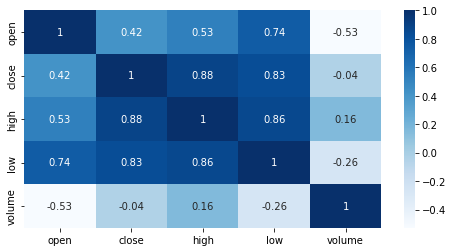

In [8]:
#heatmap correlation
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df.corr(), cmap='Blues', annot=True, ax=ax)

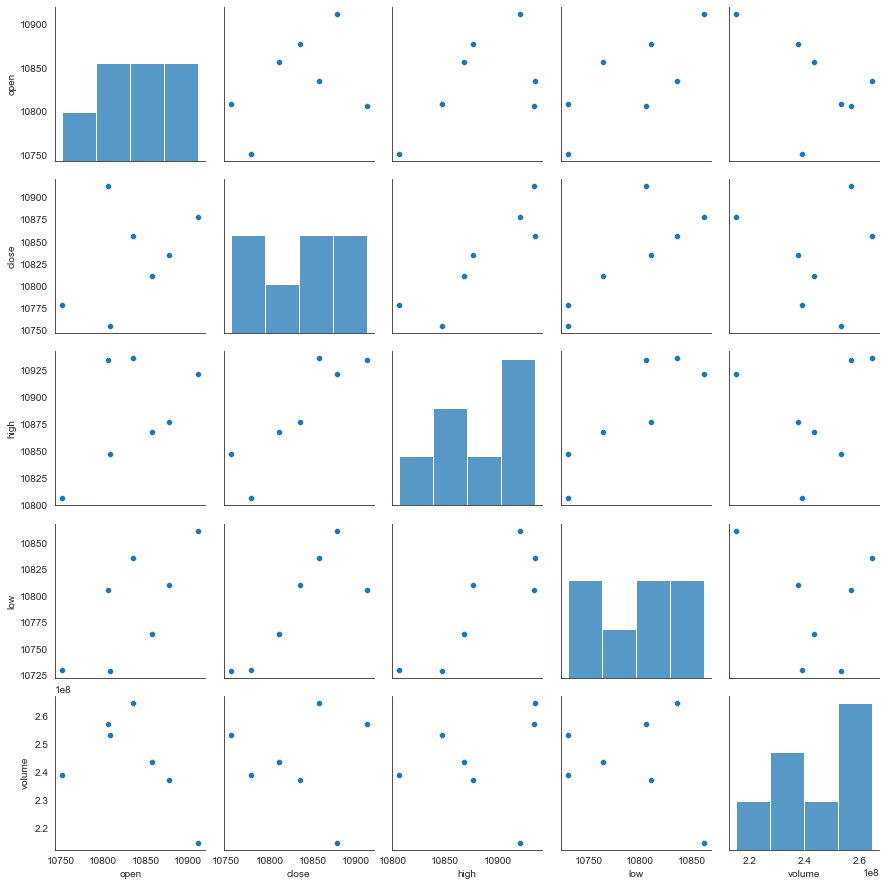

In [9]:
#pairplot

sns.set_style('white')
sns.pairplot(df,  palette = 'CMRmap')

#### Feature Engineering

In [10]:
def add_feat_prev_day(df, df_new):
    ''' this function takes a df and a new df, 
    adds to the new df the 6 cols from the original df 
    and 5 new which are the previous day ones'''
    df_new['open'] = df['open']
    df_new['close'] = df['close'] #target variable
    df_new['high'] = df['high']
    df_new['low'] = df['low']
    df_new['volume'] = df['volume']
    
    
    ### shift 1 
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    

In [11]:
def add_avg_price(df, df_new):
    '''
    add 6 features related to the average prices of the last 5, 30, and 365 days
    and their reciprocal ratios

    '''
    df_new['avg_price_5'] = df['close'].rolling(5).mean().shift(1) # past 5 days average close price
    df_new['avg_price_30'] = df['close'].rolling(21).mean().shift(1) # past 21 days average close price - 21 trading days
    df_new['avg_price_365'] = df['close'].rolling(252).mean().shift(1) # past 5 days average close price - 252 trading days
    
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']

In [12]:
def add_avg_volume(df, df_new):
    '''
    add 6 features related to the average volumes of the last 5, 30, and 365 days
    and their reciprocal ratios
    
    '''
    df_new['avg_volume_5'] = df['volume'].rolling(5).mean().shift(1) # past 5 days average close volume
    df_new['avg_volume_30'] = df['volume'].rolling(21).mean().shift(1) # past 21 days average close volume - 21 trading days
    df_new['avg_volume_365'] = df['volume'].rolling(252).mean().shift(1) # past 5 days average close volume - 252 trading days
    
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']


In [13]:
def add_std_price(df, df_new):
    '''
    add 6 features related to the average standard deviation of close price of the last 5, 30, and 365 days
    and their reciprocal ratios
    
    '''
   
    df_new['std_price_5'] = df['close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['close'].rolling(252).std().shift(1)
    
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']


In [14]:
def add_std_volume(df, df_new):
    '''
    add 6 features related to the average standard deviation of volume of the last 5, 30, and 365 days
    and their reciprocal ratios
    
    '''
   
    df_new['std_volume_5'] = df['volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(252).std().shift(1)
    
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']


In [15]:
def add_return_feature(df, df_new):
    '''add 7 return-based features
    Return is defined as the percentage of gain or loss of close price for a stock or index in a period.
    for example, daily or annual return'''
    df_new['return_1'] = (df['close'] -df['close'].shift(1))/ df['close'].shift(1).shift(1) #return on previous day
    df_new['return_5'] = (df['close'] -df['close'].shift(5))/ df['close'].shift(5).shift(1) #return on previous week
    df_new['return_30'] = (df['close'] -df['close'].shift(21))/ df['close'].shift(21).shift(1) #return on previous month
    df_new['return_365'] = (df['close'] -df['close'].shift(252))/ df['close'].shift(252).shift(1) #return on previous year
    
    df_new['ma_return_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['ma_return_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['ma_return_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    
   

In [16]:
# main function
def generate_features(df):
    '''Generate features for a stock/index based on historical data
    df with cols "open", "close", "high", "low", "volume" 
    sorted by date
    '''
    
    df_new = pd.DataFrame()
    # add date
    df_new['date']= df['date']
    # original features and shift
    add_feat_prev_day(df, df_new)
    # feature engineering 31 new features
    add_avg_price(df, df_new)
    add_avg_price(df, df_new)
    add_avg_volume(df, df_new)
    add_std_price(df, df_new)
    add_std_volume(df, df_new)
    add_return_feature(df, df_new)
    
    #we can add more features using pandas-ta
    inertia_10 = ta.inertia(close = df_new['close'])
    df_new['inertia'] = inertia_10
    sma10 = ta.sma(df_new["close"], length=10)
    df_new['sma10'] = sma10

    df_new = df_new.dropna(axis=0)
    
    return df_new

#### DJIA from 1988 to 2019

In [17]:
#https://www.investing.com/indices/us-30-historical-data

In [18]:
df_dj = pd.read_csv('Dow Jones Industrial Average Historical Data (1988 -2022).csv')
df_dj = clean_df(df_dj)
df_dj.head()

C:\Users\gpoggi\AppData\Local\Temp\ipykernel_22040\2860773912.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns =df.columns.str.replace('*','')


date     open    close     high      low  volume
0  1988-01-02  1958.39  1944.63  1973.14  1944.13   35.26
1  1988-01-03  2070.29  2070.46  2079.41  2056.70   23.63
2  1988-01-06  2030.76  2064.01  2072.37  2027.20   34.98
3  1988-01-07  2141.71  2131.58  2144.91  2122.51   14.34
4  1988-01-08  2128.73  2130.51  2137.09  2122.87   14.45

In [19]:
df_dj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8753 entries, 0 to 3454
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8753 non-null   object 
 1   open    8753 non-null   float64
 2   close   8753 non-null   float64
 3   high    8753 non-null   float64
 4   low     8753 non-null   float64
 5   volume  8753 non-null   float64
dtypes: float64(5), object(1)
memory usage: 478.7+ KB


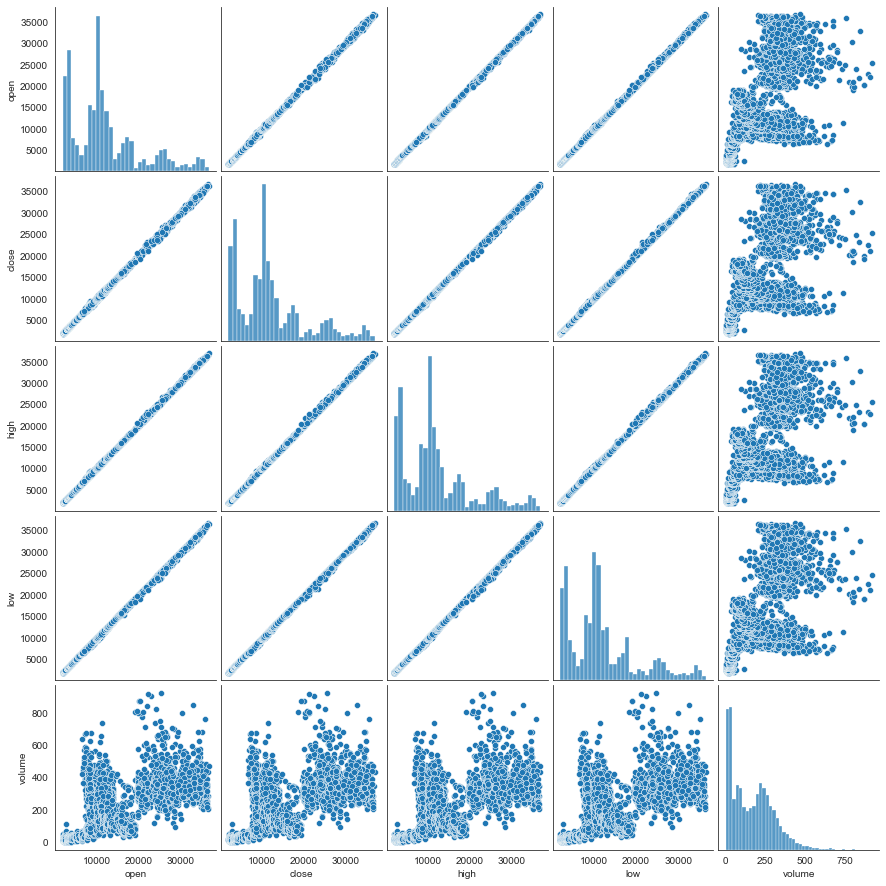

In [20]:
#pairplot

sns.set_style('white')
sns.pairplot(df_dj,  palette = 'CMRmap')

In [21]:
df_dj.isnull().sum()

date      0
open      0
close     0
high      0
low       0
volume    0
dtype: int64

In [22]:
#df_dj = clean_df(df_dj) #cleaned above
df_dj = generate_features(df_dj)
df_dj.head()

date     open    close     high      low  volume   open_1  close_1  \
100  1989-01-03  2258.39  2243.04  2272.14  2237.32   20.02  2344.82  2338.21   
101  1989-01-05  2418.44  2414.96  2418.44  2397.36   14.11  2258.39  2243.04   
102  1989-01-06  2479.78  2490.63  2496.88  2477.02   60.82  2418.44  2414.96   
103  1989-01-08  2660.66  2641.12  2676.97  2635.62   33.28  2479.78  2490.63   
104  1989-01-09  2737.27  2752.09  2758.17  2732.71   16.86  2660.66  2641.12   

      high_1    low_1  ...  ratio_std_volume_30_365  return_1  return_5  \
100  2350.18  2331.07  ...                 1.001585 -0.043886  0.037051   
101  2272.14  2237.32  ...                 1.014635  0.073526  0.114918   
102  2418.44  2397.36  ...                 1.012204  0.033735  0.142146   
103  2496.88  2477.02  ...                 1.706354  0.062316  0.216500   
104  2676.97  2635.62  ...                 1.753840  0.044555  0.190854   

     return_30  return_365  ma_return_5  ma_return_30  ma_return_365  \
100   0.067041    0.086469     0.015512      0.007907       0.000588   
101   0.211821    0.137296     0.007313      0.002686       0.000427   
102   0.202231    0.168945     0.021672      0.009599       0.000589   
103   0.288439    0.299839     0.026917      0.008392       0.000725   
104   0.333602    0.300218     0.040682      0.012694       0.001211   

       inertia     sma10  
100  48.552000  2192.161  
101  49.426964  2217.050  
102  51.318090  2249.649  
103  55.095013  2297.725  
104  60.271823  2356.041  

[5 rows x 44 columns]

In [23]:
df_dj.tail()

date      open     close      high       low  volume    open_1  \
3450  2022-12-04  34412.51  34220.36  34669.97  34102.81  333.51  36336.16   
3451  2022-12-05  31699.04  31730.04  31907.70  31231.27  525.90  34412.51   
3452  2022-12-07  31113.31  30985.02  31346.10  30860.83  315.33  31699.04   
3453  2022-12-08  33430.72  33761.11  33765.02  33398.32  286.95  31113.31   
3454  2022-12-09  32260.54  32383.18  32503.16  32259.33  324.91  33430.72   

       close_1    high_1     low_1  ...  ratio_std_volume_30_365  return_1  \
3450  36290.32  36453.49  36168.15  ...                 0.806365 -0.062092   
3451  34220.36  34669.97  34102.81  ...                 0.658724 -0.068622   
3452  31730.04  31907.70  31231.27  ...                 0.759769 -0.021771   
3453  30985.02  31346.10  30860.83  ...                 0.756837  0.087491   
3454  33761.11  33765.02  33398.32  ...                 0.781138 -0.044471   

      return_5  return_30  return_365  ma_return_5  ma_return_30  \
3450 -0.002663   0.109775   -0.010489     0.021520      0.009661   
3451 -0.003041   0.023043   -0.064781     0.001249      0.006919   
3452 -0.005984   0.008960   -0.086393     0.002542      0.003346   
3453  0.013600   0.116501   -0.014658     0.002029      0.002793   
3454 -0.117201   0.076435   -0.069520     0.005947      0.007762   

      ma_return_365    inertia      sma10  
3450       0.000664  37.208979  33840.950  
3451       0.000436  38.535401  33683.009  
3452       0.000234  38.613374  33156.309  
3453       0.000154  39.727557  33058.614  
3454       0.000461  39.569336  33002.513  

[5 rows x 44 columns]

<AxesSubplot:>

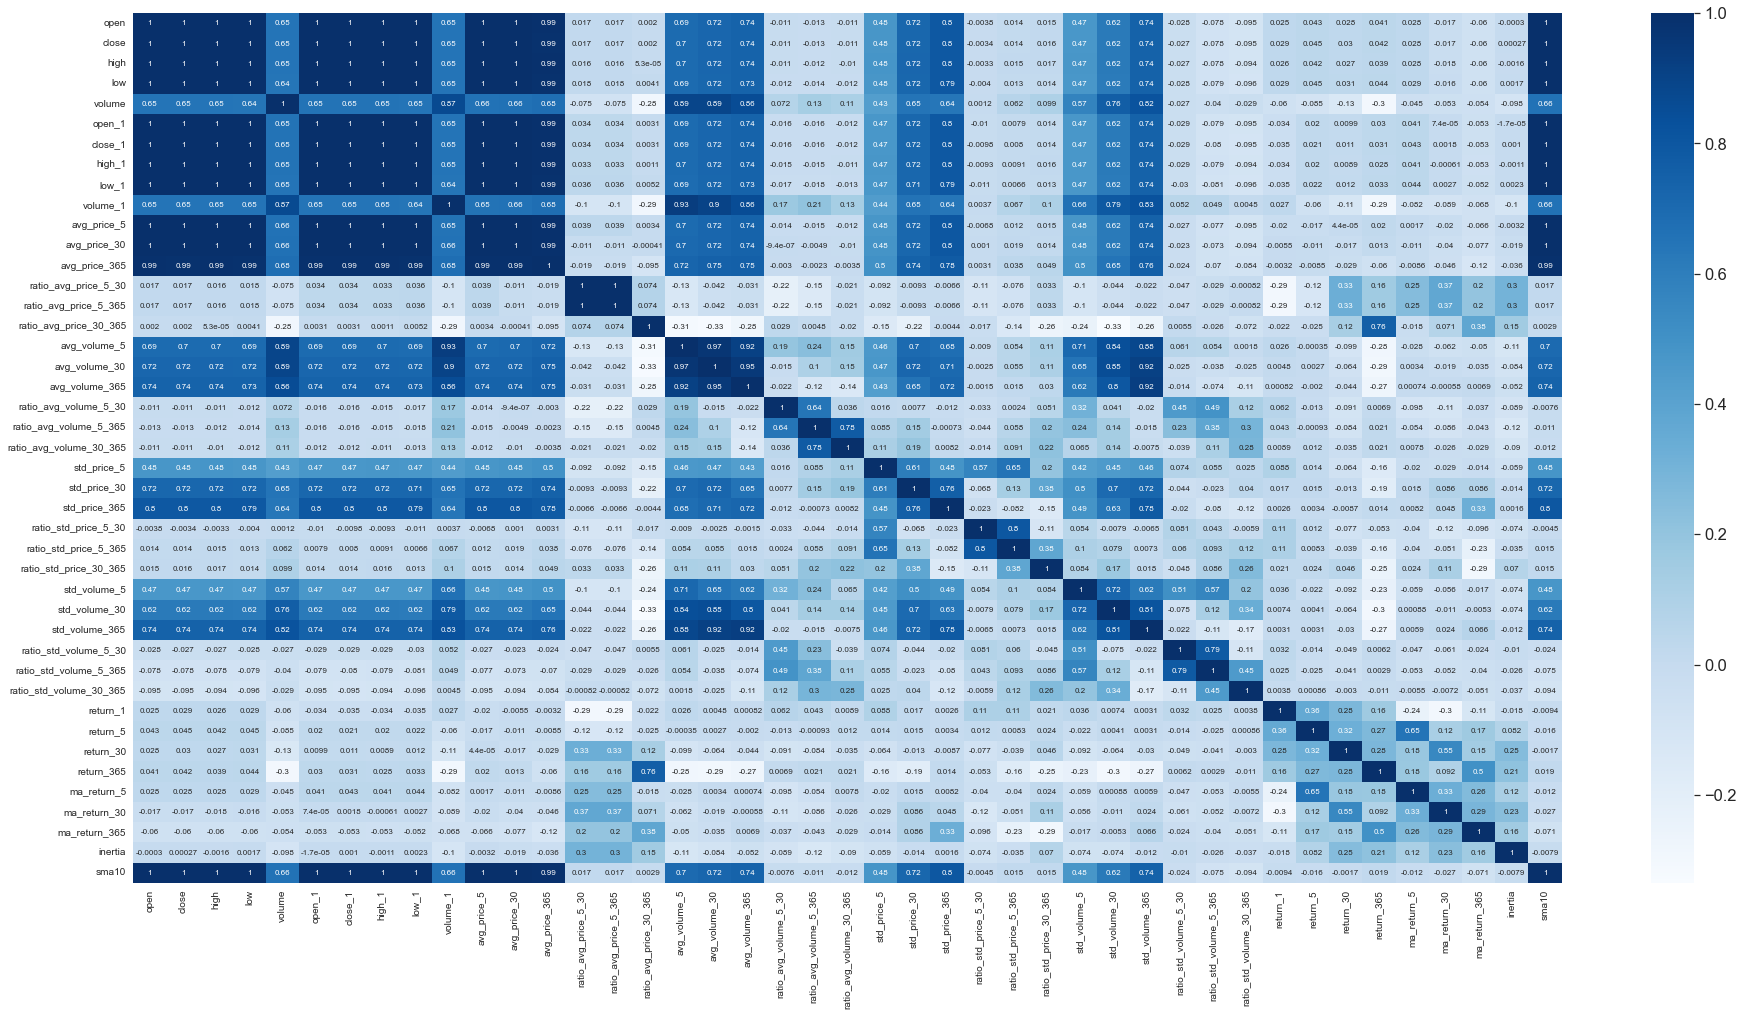

In [24]:
#heatmap correlation
fig, ax = plt.subplots(figsize=(32,16))
sns.set(font_scale=1.5)
sns.heatmap(df_dj.corr(), cmap='Blues', annot=True, ax=ax, annot_kws={"size":8})

<AxesSubplot:>

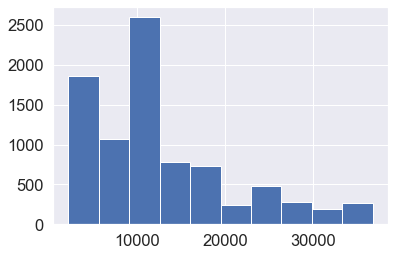

In [25]:
df_dj['close'].hist()

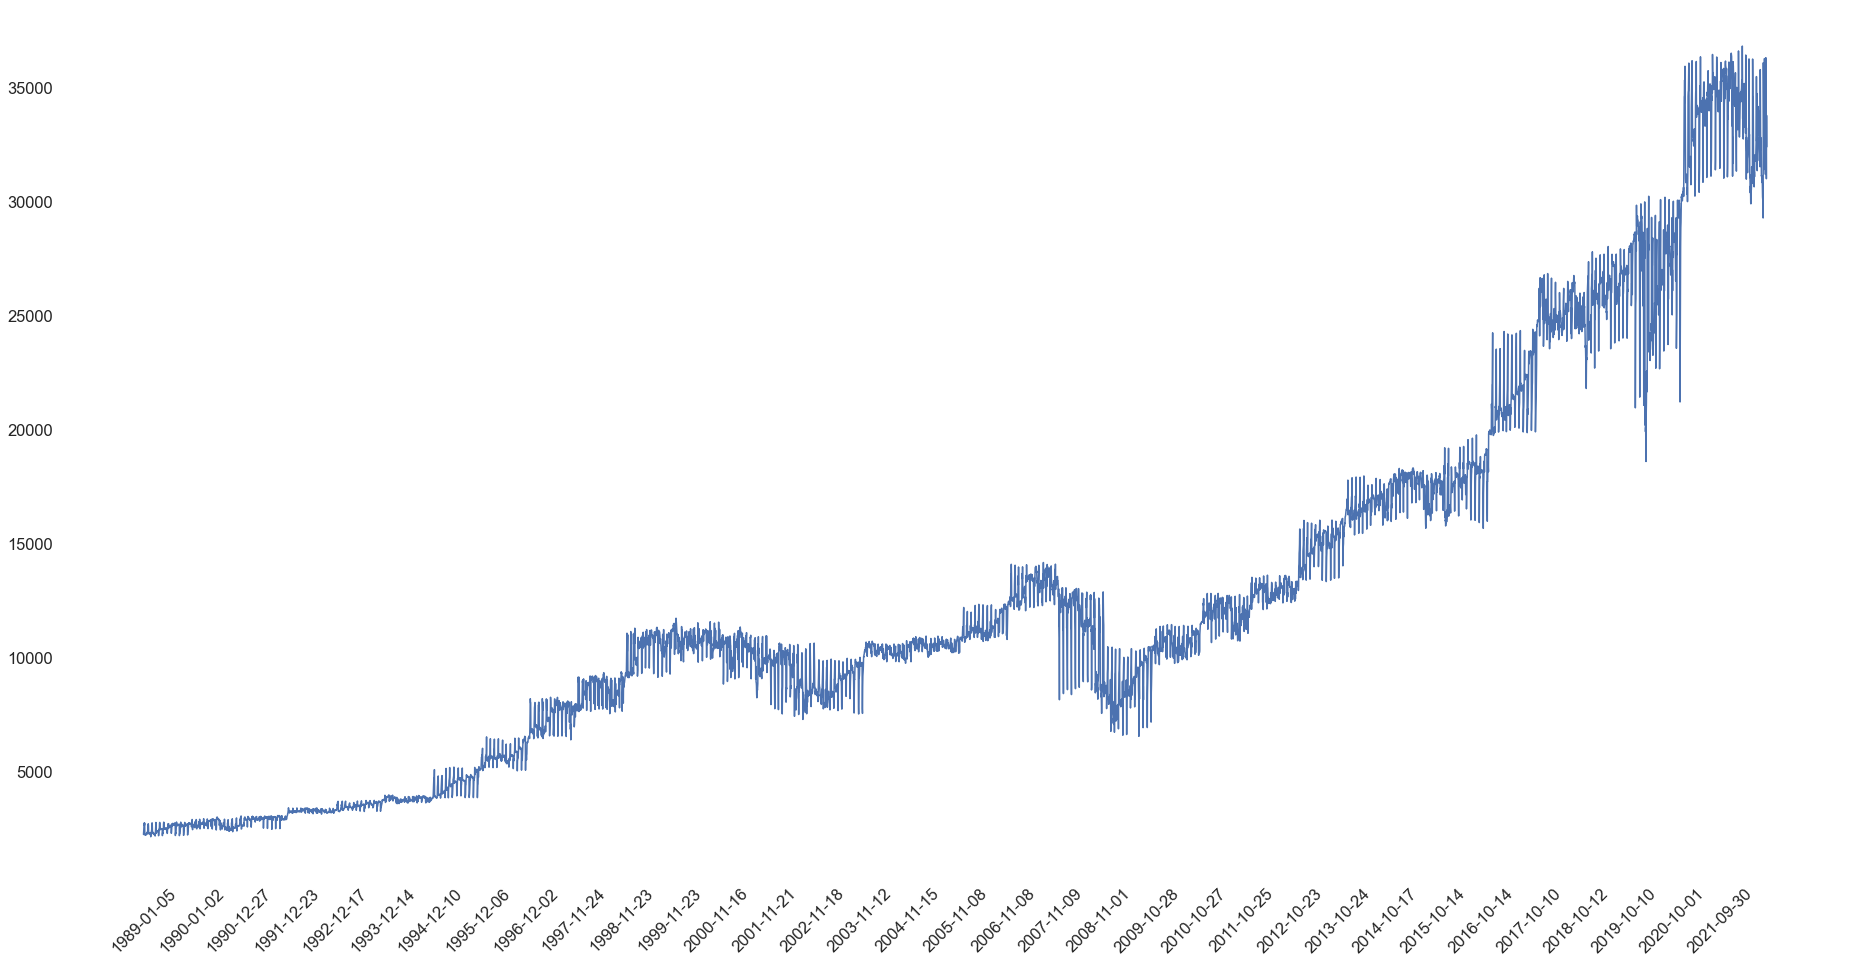

In [26]:
fig, ax = plt.subplots(figsize=(32,16))
plt.plot(df_dj['date'], df_dj['close'])

plt.xticks([df_dj['date'].to_list()[i] for i in np.arange(1, len(df_dj['date']), 250)], rotation=45)
ax.set_facecolor('white')
plt.show()

In [27]:
df_dj.columns

Index(['date', 'open', 'close', 'high', 'low', 'volume', 'open_1', 'close_1',
       'high_1', 'low_1', 'volume_1', 'avg_price_5', 'avg_price_30',
       'avg_price_365', 'ratio_avg_price_5_30', 'ratio_avg_price_5_365',
       'ratio_avg_price_30_365', 'avg_volume_5', 'avg_volume_30',
       'avg_volume_365', 'ratio_avg_volume_5_30', 'ratio_avg_volume_5_365',
       'ratio_avg_volume_30_365', 'std_price_5', 'std_price_30',
       'std_price_365', 'ratio_std_price_5_30', 'ratio_std_price_5_365',
       'ratio_std_price_30_365', 'std_volume_5', 'std_volume_30',
       'std_volume_365', 'ratio_std_volume_5_30', 'ratio_std_volume_5_365',
       'ratio_std_volume_30_365', 'return_1', 'return_5', 'return_30',
       'return_365', 'ma_return_5', 'ma_return_30', 'ma_return_365', 'inertia',
       'sma10'],
      dtype='object')

#### train test split

In [28]:
from sklearn.model_selection import train_test_split
features = df_dj.drop(['date', #drop date
                         'high', 'low', 'volume', #drop I can't use the same intra-day actuals to predict
                       'close'] #drop as it is target
                       , axis=1)
target =df_dj['close']
features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.03, random_state=42, 
    shuffle=False, stratify = None)# Shuffle False because it's a time series

#### Scaling Features

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test) #only fit on training data

In [30]:
#save results

results = pd.DataFrame(columns={'model', 'MAE', 'MSE', 'R2'})

#### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
model_lin_base = LinearRegression()
model_lin_base.fit(features_train_scaled, target_train)
target_test_pred_base = model_lin_base.predict(features_test_scaled)
print('MAE: ', mean_absolute_error(target_test,target_test_pred_base))
print('MSE: ', mean_squared_error(target_test,target_test_pred_base))
print('R2: ', r2_score(target_test,target_test_pred_base))

MAE:  251.84748615458153
MSE:  102262.05454522482
R2:  0.9675232220101136


In [33]:
results = pd.concat([results, 
           pd.DataFrame({
            'model': ['linear_base'], 
            'MAE': [mean_absolute_error(target_test,target_test_pred_base)],
            'MSE':[mean_squared_error(target_test,target_test_pred_base)],
            'R2': [r2_score(target_test,target_test_pred_base)]       
})])

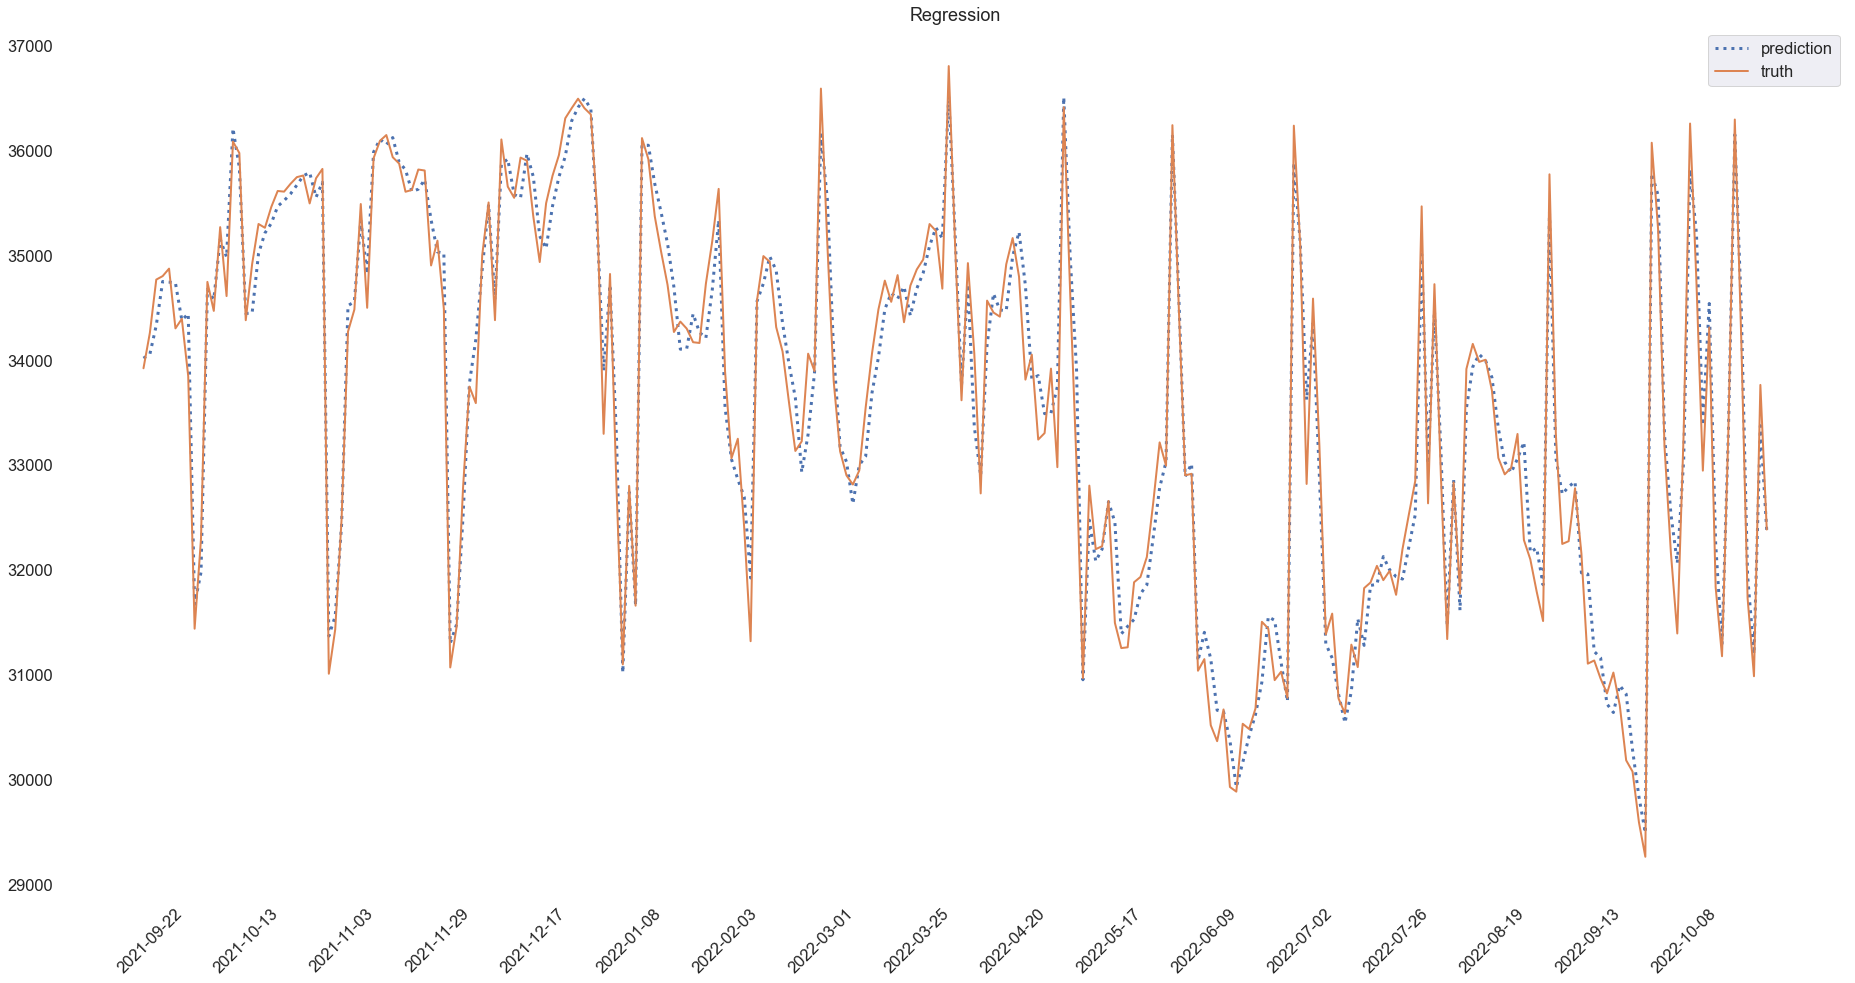

In [34]:
#plot prediction vs real values
fig, ax = plt.subplots(figsize=(32,16))
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_pred_base, label='prediction', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test, label='truth', linewidth=2)
plt.xticks([df_dj['date'].iloc[-len(features_test):].to_list()[i] for i in 
            np.arange(1, len(df_dj['date'].iloc[-len(features_test):]), 15)], rotation=45)
ax.legend()
ax.set(title='Regression')

ax.set_facecolor('white')
plt.show()

#### Elastic Net Regression with CV

In [35]:
from sklearn.linear_model import ElasticNetCV

In [36]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
l1l2ratios = [.1, .5,.7, .9, .95, .97, .99, 1]
elnet = ElasticNetCV(cv=5, random_state = 42, l1_ratio = l1l2ratios, alphas = alphas, max_iter=10000,
                     tol = 0.001,
                     n_jobs=-1)

In [37]:
elnet.fit(features_train_scaled, target_train)

ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1], cv=5,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.97, 0.99, 1], max_iter=10000,
             n_jobs=-1, random_state=42, tol=0.001)

In [38]:
print('elastic net l1_ratio',elnet.l1_ratio_, '\n', 'alpha', elnet.alpha_ )

elastic net l1_ratio 1.0 
 alpha 0.3


In [39]:
target_test_pred_elnet = elnet.predict(features_test_scaled)
print('MAE: ', mean_absolute_error(target_test,target_test_pred_elnet))
print('MSE: ', mean_squared_error(target_test,target_test_pred_elnet))
print('R2: ', r2_score(target_test,target_test_pred_elnet))
results = pd.concat([results, 
           pd.DataFrame({
            'model': ['elastic_net_regr'], 
            'MAE': [mean_absolute_error(target_test,target_test_pred_elnet)],
            'MSE':[mean_squared_error(target_test,target_test_pred_elnet)],
            'R2': [r2_score(target_test,target_test_pred_elnet)]       
})])

MAE:  251.25599994017648
MSE:  104395.59677102481
R2:  0.9668456434350743


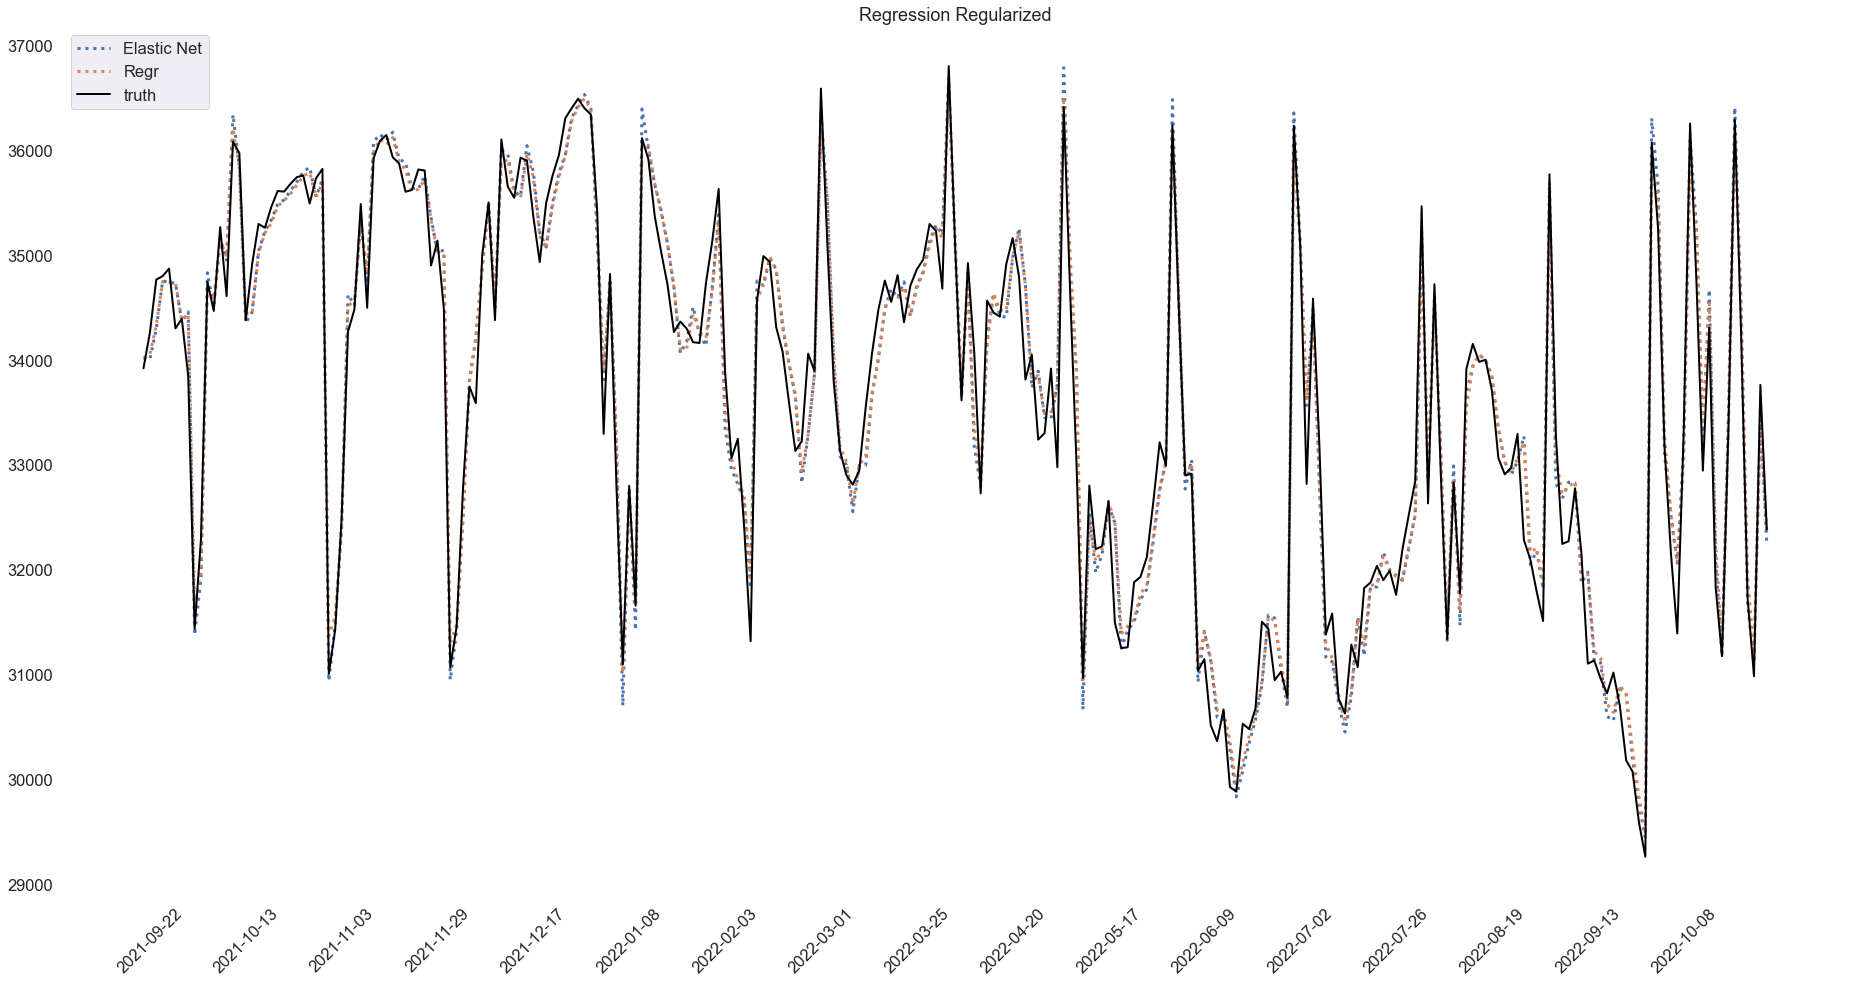

In [40]:
#plot prediction vs real values
fig, ax = plt.subplots(figsize=(32,16))
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_pred_elnet, label='Elastic Net', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_pred_base, label='Regr', linestyle=':', linewidth=3)

plt.plot(df_dj['date'].iloc[-len(features_test):], target_test, label='truth', linewidth=2, color='black')
plt.xticks([df_dj['date'].iloc[-len(features_test):].to_list()[i] for i in 
            np.arange(1, len(df_dj['date'].iloc[-len(features_test):]), 15)], rotation=45)
ax.legend()
ax.set(title='Regression Regularized')

ax.set_facecolor('white')
plt.show()

#### Regression Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
model_forest = RandomForestRegressor(n_estimators = 100, max_depth = 10, min_samples_split = 3)

In [43]:
model_forest.fit(features_train_scaled, target_train)
target_test_prest_forest = model_forest.predict(features_test_scaled)
print('MAE: ', mean_absolute_error(target_test,target_test_prest_forest))
print('MSE: ', mean_squared_error(target_test,target_test_prest_forest))
print('R2: ', r2_score(target_test,target_test_prest_forest))

results = pd.concat([results, 
           pd.DataFrame({
            'model': ['forest'], 
            'MAE': [mean_absolute_error(target_test,target_test_prest_forest)],
            'MSE':[mean_squared_error(target_test,target_test_prest_forest)],
            'R2': [r2_score(target_test,target_test_prest_forest)]       
})])

MAE:  280.6012755469474
MSE:  120955.01341696572
R2:  0.9615866399812133


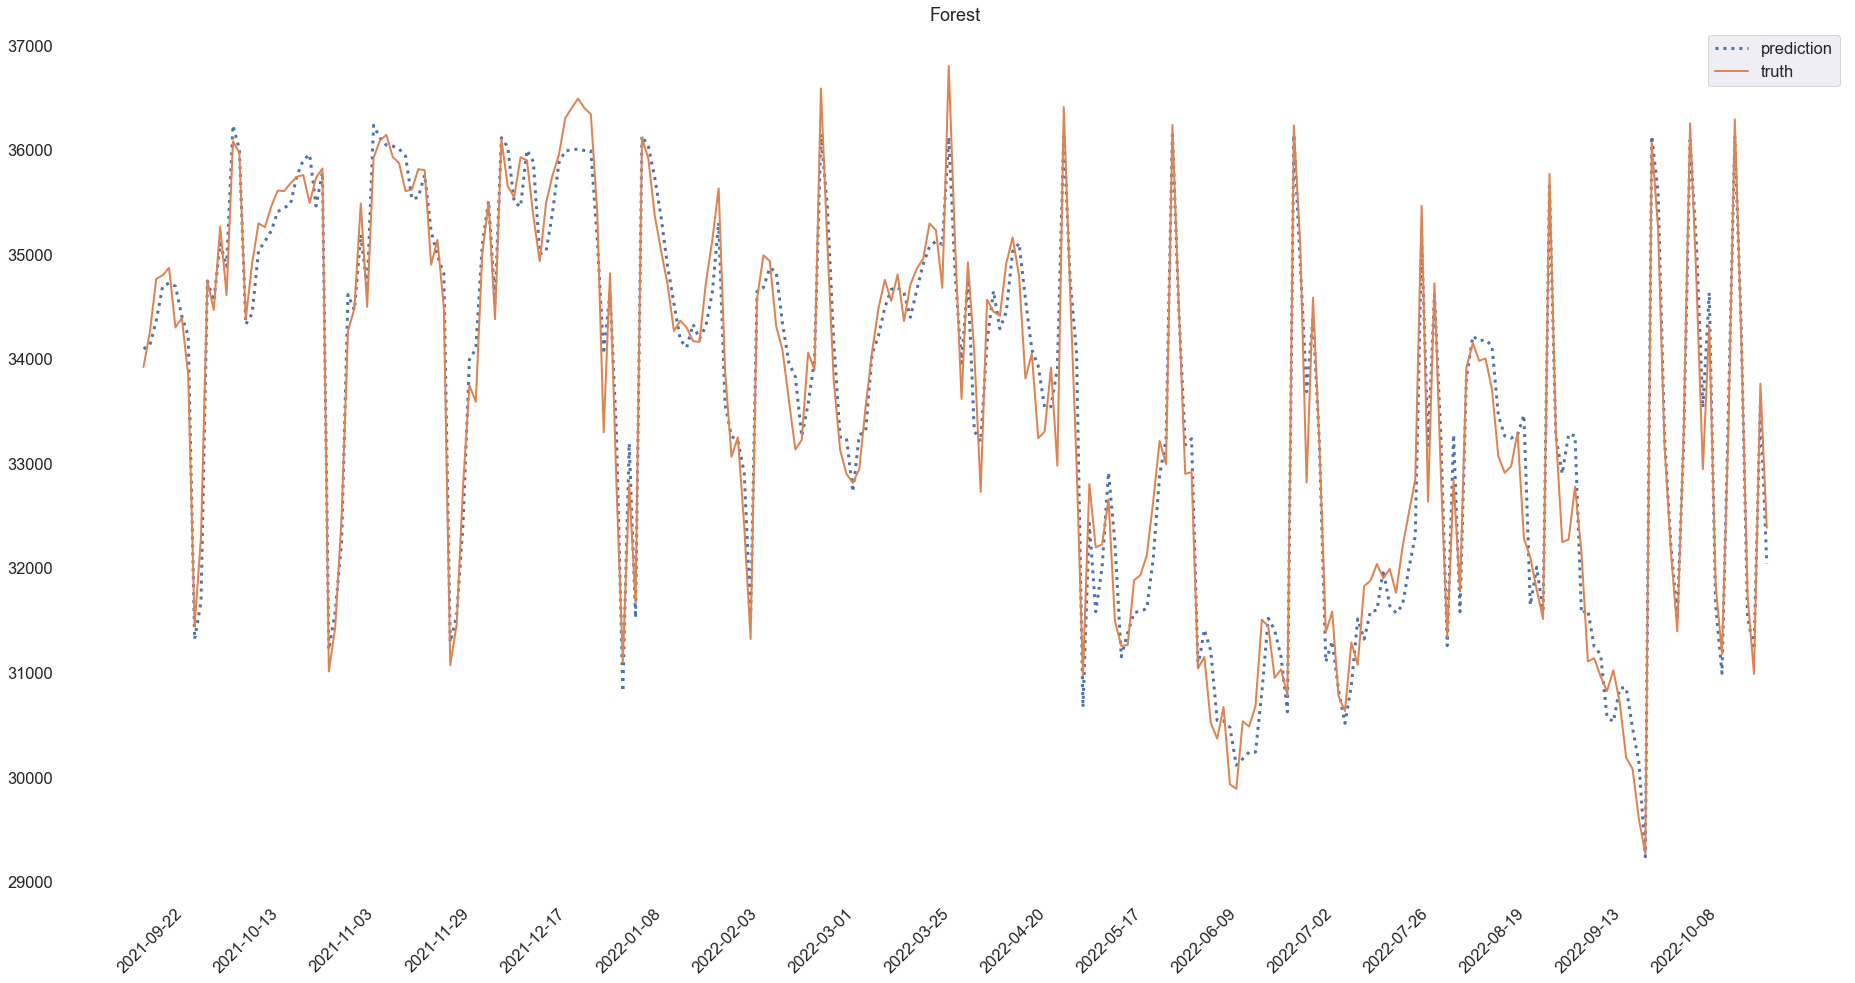

In [44]:
#plot prediction vs real values
fig, ax = plt.subplots(figsize=(32,16))
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_prest_forest, label='prediction', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test, label='truth', linewidth=2)
plt.xticks([df_dj['date'].iloc[-len(features_test):].to_list()[i] for i in 
            np.arange(1, len(df_dj['date'].iloc[-len(features_test):]), 15)], rotation=45)
ax.set(title='Forest')
ax.legend()
ax.set_facecolor('white')
plt.show()

##### GridSearch Forest

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.model_selection import TimeSeriesSplit

timeseriescv = TimeSeriesSplit()

In [47]:
search_space_rf = {
    'n_estimators' : np.geomspace(start=1, stop=1000, num = 5, dtype='int'),
    'max_depth' : np.geomspace(start=1, stop=20, num = 5, dtype='int'), 
    'min_samples_split':np.geomspace(start=3, stop=1000, num = 5,  dtype='int')
    
    
}

In [48]:
model_rf_grid = GridSearchCV(estimator = model_forest,
                            param_grid = search_space_rf,
                            scoring ='r2',
                            return_train_score = True, n_jobs=-1,
                            cv = timeseriescv
                            
                            )
model_rf_grid.fit(features_train_scaled, target_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(max_depth=10, min_samples_split=3),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  4,  9, 20]),
                         'min_samples_split': array([   3,   12,   54,  234, 1000]),
                         'n_estimators': array([   1,    5,   31,  177, 1000])},
             return_train_score=True, scoring='r2')

In [49]:
model_rf_grid.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_split=12, n_estimators=1)

In [50]:
model_rf_grid.best_score_

-0.34511425198106666

In [51]:

target_test_prest_forest_grid = model_rf_grid.predict(features_test_scaled)
print('MAE: ', mean_absolute_error(target_test,target_test_prest_forest_grid))
print('MSE: ', mean_squared_error(target_test,target_test_prest_forest_grid))
print('R2: ', r2_score(target_test,target_test_prest_forest_grid))


results = pd.concat([results, 
           pd.DataFrame({
            'model': ['forest_grid'], 
            'MAE': [mean_absolute_error(target_test,target_test_prest_forest_grid)],
            'MSE':[mean_squared_error(target_test,target_test_prest_forest_grid)],
            'R2': [r2_score(target_test,target_test_prest_forest_grid)]       
})])

MAE:  360.40756344512783
MSE:  221083.5391881273
R2:  0.9297874362943119


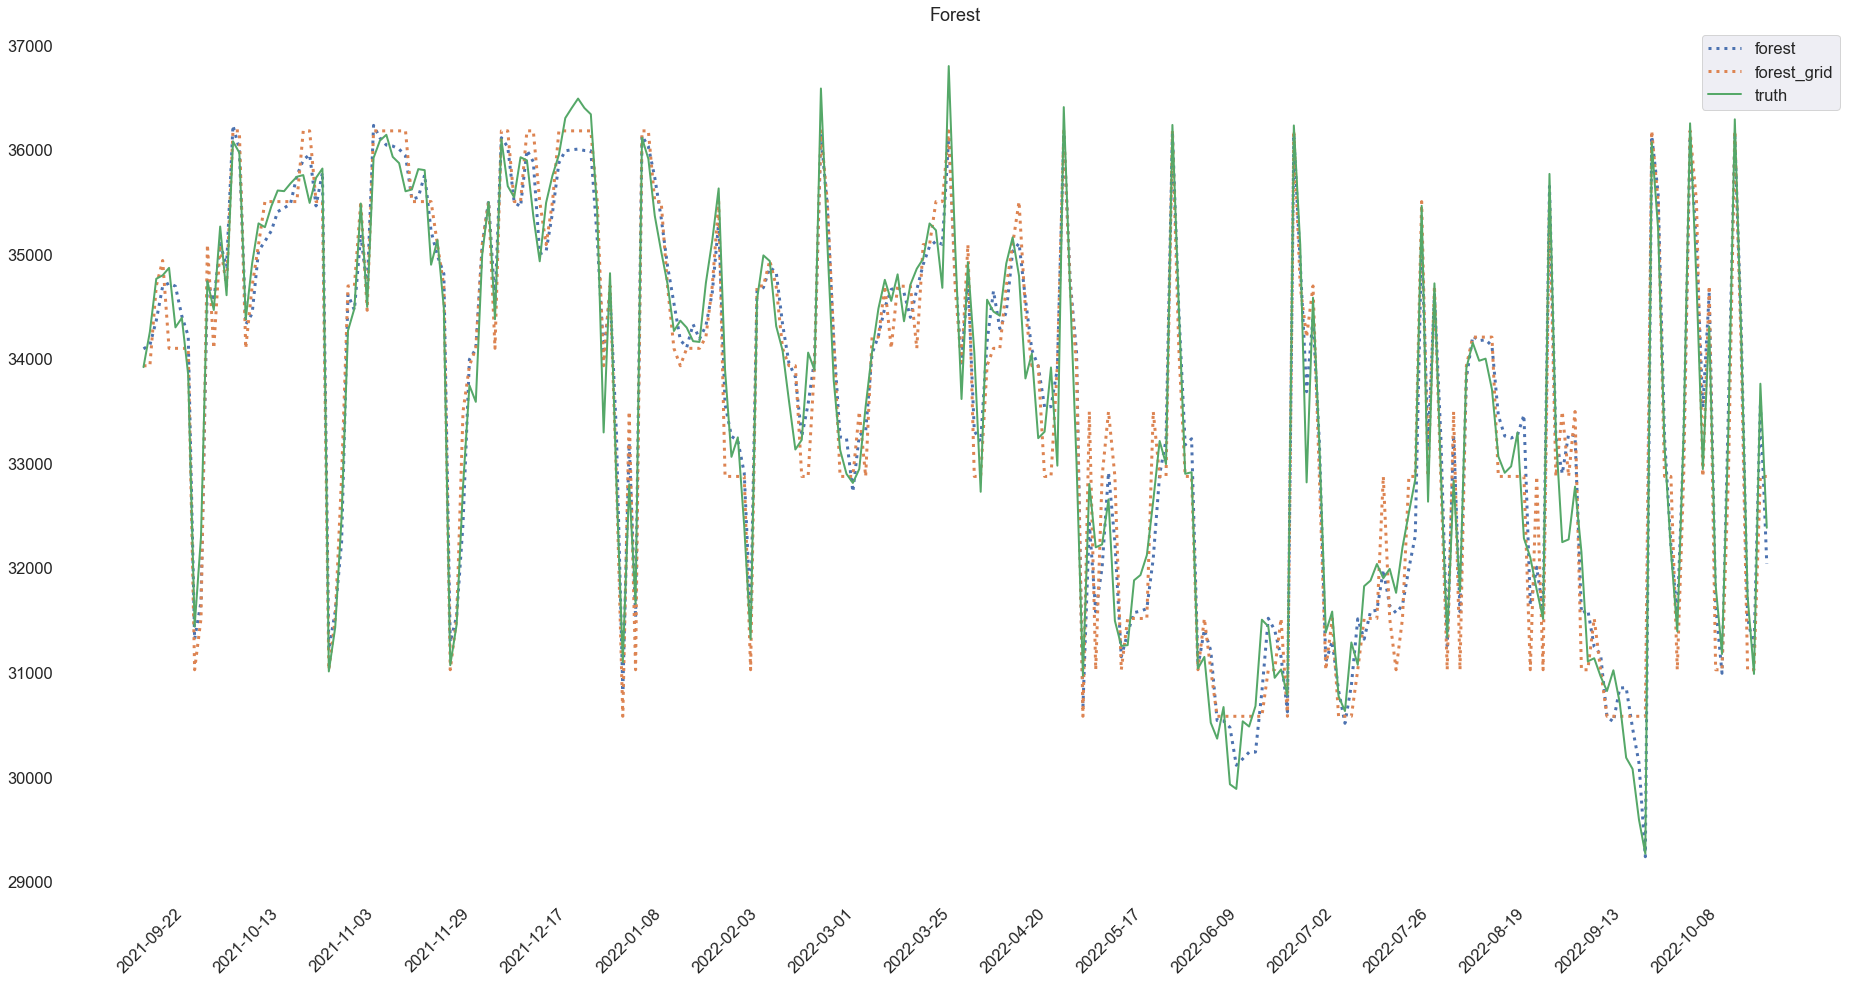

In [52]:
#plot prediction vs real values
fig, ax = plt.subplots(figsize=(32,16))
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_prest_forest, label='forest', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_prest_forest_grid, label='forest_grid', 
         linestyle=':', linewidth=3)

plt.plot(df_dj['date'].iloc[-len(features_test):], target_test, label='truth', linewidth=2)
plt.xticks([df_dj['date'].iloc[-len(features_test):].to_list()[i] for i in 
            np.arange(1, len(df_dj['date'].iloc[-len(features_test):]), 15)], rotation=45)
ax.set(title='Forest')
ax.legend()
ax.set_facecolor('white')
plt.show()

#### SVR

In [53]:
from sklearn.svm import SVR
svr_model = SVR( kernel='linear')
svr_model.fit(features_train_scaled, target_train)
target_test_svr = svr_model.predict(features_test_scaled)
print('MAE: ', mean_absolute_error(target_test,target_test_svr))
print('MSE: ', mean_squared_error(target_test,target_test_svr))
print('R2: ', r2_score(target_test,target_test_svr))
results = pd.concat([results, 
           pd.DataFrame({
            'model': ['svr'], 
            'MAE': [mean_absolute_error(target_test,target_test_svr)],
            'MSE':[mean_squared_error(target_test,target_test_svr)],
            'R2': [r2_score(target_test,target_test_svr)]       
})])

MAE:  568.9180138098191
MSE:  595622.5739437517
R2:  0.810839884004275


###### SVR Grid search

In [54]:
search_space_svr = {
    'C' : np.geomspace(start=0.1, stop=1, num = 3, dtype='float'),
    'epsilon' : np.geomspace(start=0.02, stop=0.2, num = 3, dtype='float'), 
    'kernel':['linear', 'rbf']
    
    
}

In [55]:
model_svr_grid = GridSearchCV(estimator = svr_model,
                            param_grid = search_space_svr,
                            scoring ='r2',
                            return_train_score = True, n_jobs=-1,
                            cv = timeseriescv
                            
                            )
model_svr_grid.fit(features_train_scaled, target_train)
print(model_svr_grid.best_estimator_, model_svr_grid.best_score_)

SVR(epsilon=0.2, kernel='linear') -0.059189423075541446


In [56]:

target_test_prest_svr_grid = model_svr_grid.predict(features_test_scaled)
print('MAE: ', mean_absolute_error(target_test,target_test_prest_svr_grid))
print('MSE: ', mean_squared_error(target_test,target_test_prest_svr_grid))
print('R2: ', r2_score(target_test,target_test_prest_svr_grid))

results = pd.concat([results, 
           pd.DataFrame({
            'model': ['svr_grid'], 
            'MAE': [mean_absolute_error(target_test,target_test_prest_svr_grid)],
            'MSE':[mean_squared_error(target_test,target_test_prest_svr_grid)],
            'R2': [r2_score(target_test,target_test_prest_svr_grid)]       
})])

MAE:  568.876188748969
MSE:  595609.8107767624
R2:  0.8108439373801102


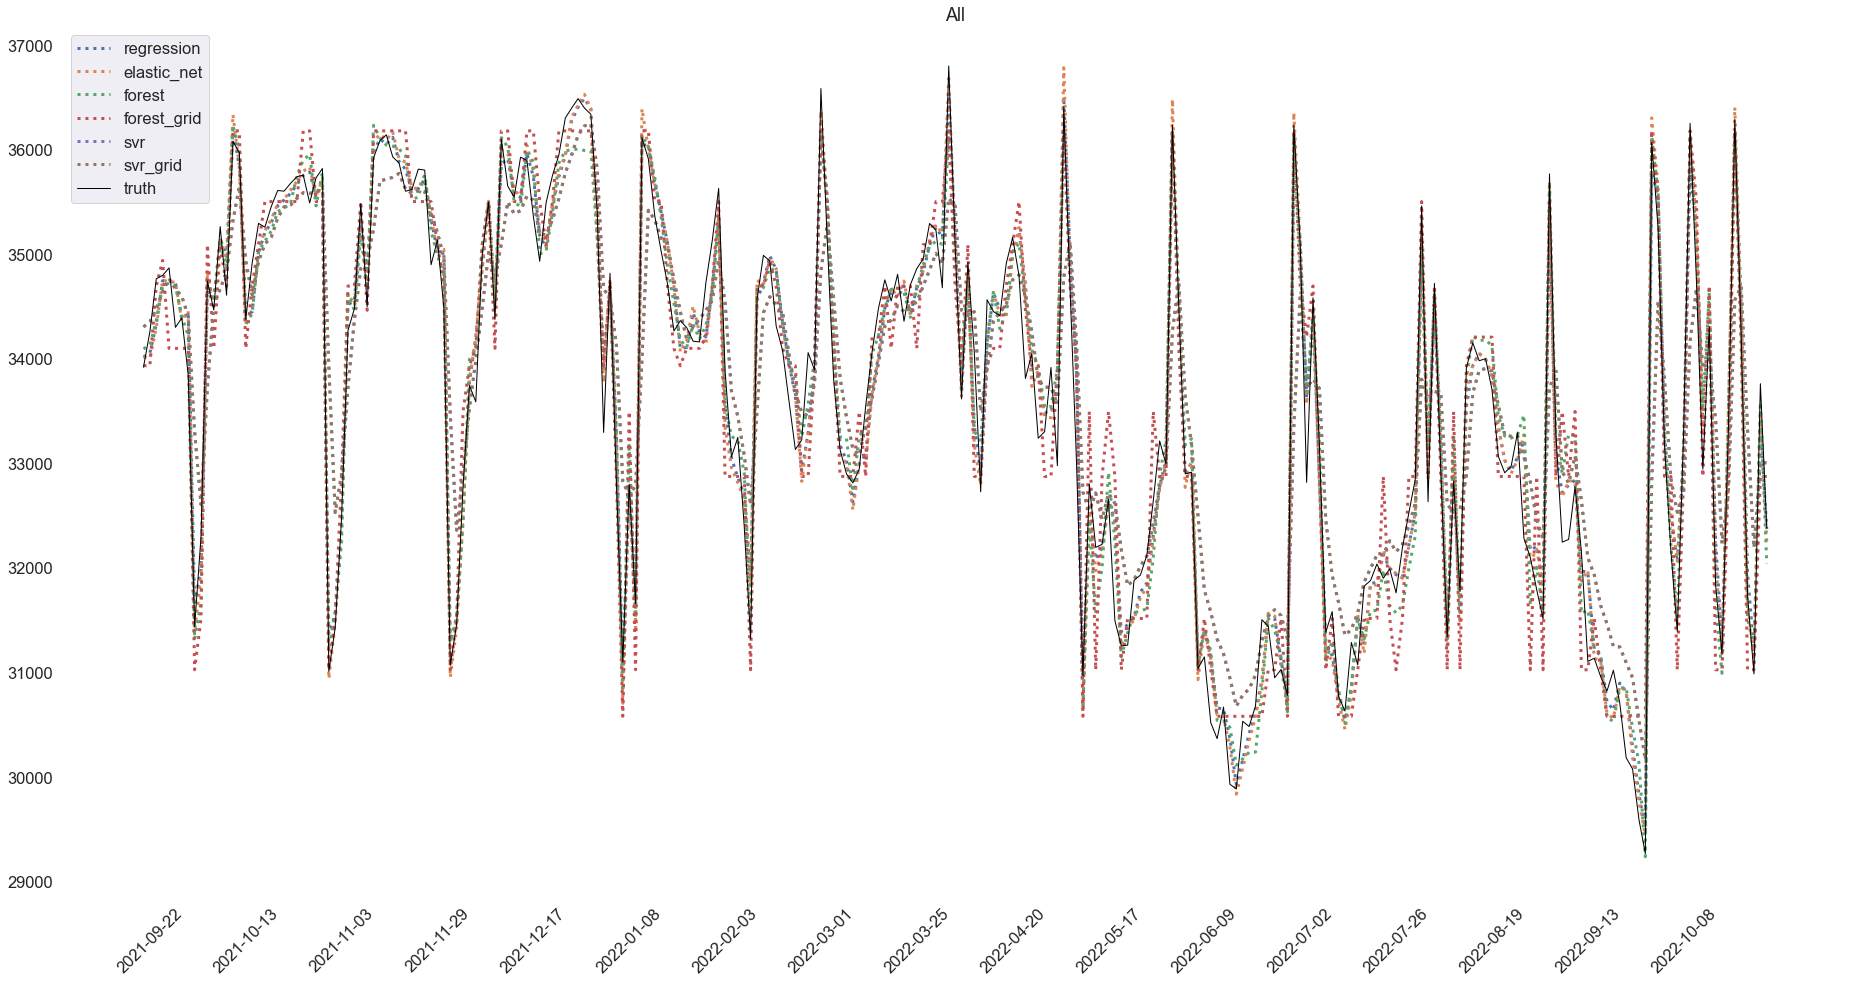

In [57]:
#plot prediction vs real values
fig, ax = plt.subplots(figsize=(32,16))
###Plot Linear
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_pred_base, label='regression', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_pred_elnet, label='elastic_net', linestyle=':', linewidth=3)

### Plot forest results
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_prest_forest, label='forest', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_prest_forest_grid, label='forest_grid', 
         linestyle=':', linewidth=3)

### Plot SVR Results
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_svr, label='svr', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-len(features_test):], target_test_prest_svr_grid, label='svr_grid', 
         linestyle=':', linewidth=3)



plt.plot(df_dj['date'].iloc[-len(features_test):], target_test, label='truth', linewidth=1, linestyle='-', color='black')
plt.xticks([df_dj['date'].iloc[-len(features_test):].to_list()[i] for i in 
            np.arange(1, len(df_dj['date'].iloc[-len(features_test):]), 15)], rotation=45)
ax.set(title='All')
ax.legend()
ax.set_facecolor('white')
plt.show()

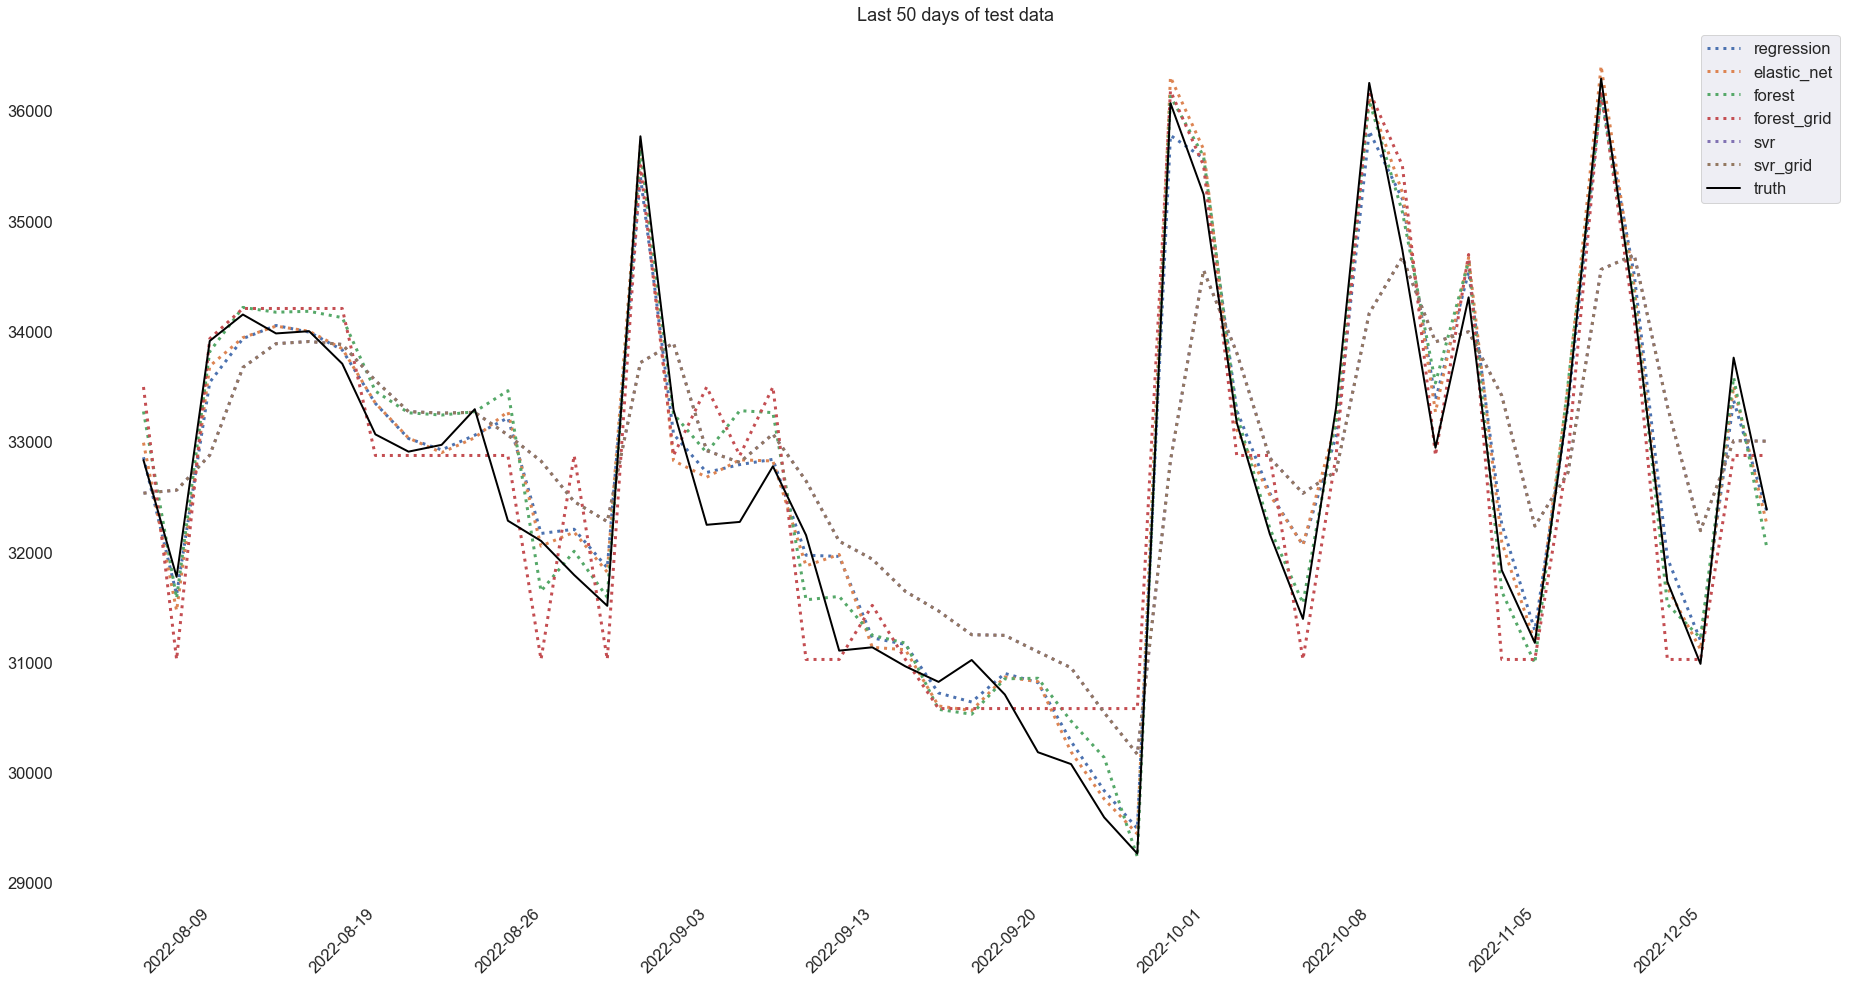

In [58]:
fig, ax = plt.subplots(figsize=(32,16))
timespan= 50
###Plot Linear

plt.plot(df_dj['date'].iloc[-timespan:], target_test_pred_base[-timespan:], label='regression', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-timespan:], target_test_pred_elnet[-timespan:], label='elastic_net', linestyle=':', linewidth=3)

### Plot forest results
plt.plot(df_dj['date'].iloc[-timespan:], target_test_prest_forest[-timespan:], label='forest', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-timespan:], target_test_prest_forest_grid[-timespan:], label='forest_grid', 
         linestyle=':', linewidth=3)

### Plot SVR Results
plt.plot(df_dj['date'].iloc[-timespan:], target_test_svr[-timespan:], label='svr', linestyle=':', linewidth=3)
plt.plot(df_dj['date'].iloc[-timespan:], target_test_prest_svr_grid[-timespan:], label='svr_grid', 
         linestyle=':', linewidth=3)

#truth
plt.plot(df_dj['date'].iloc[-timespan:], target_test[-timespan:], label='truth', linewidth=2, linestyle='-', color='black')


plt.xticks([df_dj['date'].iloc[-timespan:].to_list()[i] for i in 
            np.arange(1, len(df_dj['date'].iloc[-timespan:]), 5)], rotation=45)
ax.set(title='Last '+str(timespan)+ ' days of test data')
ax.legend()
ax.set_facecolor('white')
plt.show()

In [59]:
results.sort_values(by='R2', ascending=False)

MAE             model            MSE        R2
0  251.847486       linear_base  102262.054545  0.967523
0     251.256  elastic_net_regr  104395.596771  0.966846
0  280.601276            forest  120955.013417  0.961587
0  360.407563       forest_grid  221083.539188  0.929787
0  568.876189          svr_grid  595609.810777  0.810844
0  568.918014               svr  595622.573944   0.81084